# Predict fSCA from trained gradient boosted trees ML object

- Purpose: Predict fSCA using a gradient boosted trees ML model for fractional snow covered area (fSCA) using GPUs
- Creator: Cade Trotter with input from Ryan Crumley and Katrina Bennett
- Created: 2025.07.09; Last Modification: 2025.11.14
- See also: chunkedML.py
- Note: we used AI to create portions of the code below 

### Import packages / libraries

In [1]:
import xarray as xr
import numpy as np
import os
import dask
import dask.array as da
import pickle
import shap
import matplotlib.pyplot as plt

dask.config.set(array__slicing__split_large_chunks=True)

print("All modules imported successfully :)")

All modules imported successfully :)


## 1) User inputs and data paths

In [2]:
trainingWaterYears = [2019] ###in this case we are predicting on one year. You can do as many years as you have data that the model has not seen
n_chunks = len(trainingWaterYears) * 10 ### this sets how many chunks we will make. More chunks = less GPU memory at a given time
env = os.environ.copy()
env["CUDA_VISIBLE_DEVICES"] = "2"  # Or "" for all GPUs

### Base Path:
dataDirectoryPath = ###put your base dir path here. If you do not wish to follow the dir structure below, paths will need to be
### ammended to reflect that. 

### Establish File Paths to Important Datasets:

In [ ]:
### Topographic (x,y):
elevPath = "goodDemXY.nc"
slopeAspectPath = "slopeAspectBinnedXY.nc"
latLongPath = "latLongXY.nc"

### Unique (time x,y):
dayOfWaterYearPaths = [dataDirectoryPath + "dowy/dayOfWaterYearGriddedSurface" + str(waterYear) + ".nc" for waterYear in trainingWaterYears]

### Forcing Variables (time x,y):
conusPaths = [dataDirectoryPath + "conusDaily/conusData" + str(waterYear) + "Complete.nc" for waterYear in trainingWaterYears]

### FSCA 5cm Threshold for a WY (time x,y)
fscaPaths = [dataDirectoryPath + "smFsca/smFsca_regridded_" + str(waterYear-1) + str(waterYear) + "XY.nc" for waterYear in trainingWaterYears]

### Precipitation Cummulative Summation (time x,y) (derived from CONUS: tiled, cummulative sum of RAINRATE starting on each water year)
precipPaths = [dataDirectoryPath + "conusDaily/conusData" + str(waterYear) + "Complete_cumsum_of_RAINRATE.nc" for waterYear in trainingWaterYears]

### Static Paths such as elev, slope, etc:
staticList = [elevPath, slopeAspectPath, latLongPath]
staticPaths = [dataDirectoryPath + "topo/" + path for path in staticList]

### Quick Useful Check of Paths:

In [11]:
staticPaths

In [14]:
conusPaths + fscaPaths + dayOfWaterYearPaths + precipPaths

### Establish the dynamic and static predictor variables, and the target variable for the ML

In [5]:
# Define the dynamic or static predictor variables

# The dynamic variables are those that change with each timestep
dynamic_vars = ['T2D', 'LWDOWN', 'SWDOWN', 'U2D', 'V2D', 'day_of_year', 'accumulated_RAINRATE']    ### Must be (time, lat, lon)

# The static variables are those that remain the same with each timestep (usually physiographic or geographic)
static_vars = ['HGT', 'slope', "binned_aspect", "lat", "lon"]   ### Must be (lat, lon)

# The target variable
target_var = 'fSCA' ### Must be (time, x, y)

# Load Datasets Lazily 
ds_dyn = xr.open_mfdataset(conusPaths + fscaPaths + dayOfWaterYearPaths + precipPaths, combine='by_coords', parallel=True, chunks={'time': 100})
ds_static = xr.open_mfdataset(staticPaths, combine='by_coords', parallel=True)  # elevation, slope etc.

### Fix some coords issues:

In [6]:
ds_dyn = ds_dyn.reset_coords(["lat", "lon"], drop=False)
ds_dyn['lat'] = ds_dyn['lat'].transpose("x", "y")
ds_dyn['lon'] = ds_dyn['lon'].transpose("x", "y")

## 2) Reshape predictor variables and target variables for the ML

In [7]:
# Expand static variables across time 
ds_static_exp = ds_static.expand_dims(time=ds_dyn.time)
# Merge dynamic + static + target 
ds_combined = xr.merge([ds_dyn[dynamic_vars + [target_var]], ds_static_exp[static_vars]])
X_all = ds_combined[dynamic_vars + static_vars].to_array().transpose(...).data.astype(np.float32)

print("type(X_all):", type(X_all))
print("X_all.shape:", X_all.shape)
print("X_all.chunks:", X_all.chunks)


type(X_all): <class 'dask.array.core.Array'>
X_all.shape: (12, 365, 603, 870)
X_all.chunks: ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (100, 100, 100, 65), (603,), (870,))


### Transpose and flatten data for ML

In [8]:
#Transpose to get vars last
X_all = X_all.transpose(1, 2, 3, 0)  # Now shape: (365, 603, 870, 11)

#Rechunk to ensure safe reshaping (especially along the first axis)
X_all = X_all.rechunk({0: 50})  # 50 time steps per chunk

#Reshape to (samples, vars)
X_all = X_all.reshape(-1, 12)  # shape will now be (365*603*870, 11)

#Compute to NumPy
X_np = X_all.compute()
print("Final shape:", X_np.shape)

Final shape: (191482650, 12)


## 3) Read in the model and predict!

In [9]:
with open(dataDirectoryPath + "ML_model_dir/ML_model_version/model/model.pkl", 'rb') as f:
    model = pickle.load(f)

### Predict!

In [15]:
print("Attempting to predict", flush=True)
print(np.shape(X_np))
# Predict
predictFsca = model["model"].predict(X_np)

In [16]:
predictFsca


## 4) Check output and plot

In [11]:
print("np.shape(predictFsca)", np.shape(predictFsca))


np.shape(predictFsca) (191482650,)


### Reshape to (time,x,y)

In [17]:
fsca_reshaped = predictFsca.reshape(365, 603, 870)
fsca_reshaped

In [ ]:
np.shape(fsca_reshaped)

### Wrap NumPy array in a DataArray with matching coords and dims

In [29]:
predicted_da = xr.DataArray(
    data=fsca_reshaped,  # (time, x, y)
    dims=("time", "x", "y"),
    coords={
        "time": ds_combined.coords["time"],
        "x": ds_combined.coords["x"],
        "y": ds_combined.coords["y"],
    },
    name="model_prediction"  # You can choose any variable name here
)

### Add the data to the dataset, and plot for April 1

In [30]:
# Add to the dataset
ds_combined["model_prediction_fsca"] = predicted_da

### Fix values above 1 and below 0 for fSCA:

In [ ]:
print("MAX: ", np.max(ds_combined["model_prediction_fsca"]))
print("MIN: ", np.min(ds_combined["model_prediction_fsca"]))
print("MEAN: ", np.mean(ds_combined["model_prediction_fsca"]))
combined["ML"] = ds_combined["model_prediction_fsca"].where(ds_combined["model_prediction_fsca"] >= 0, 0)  # set values < 0 to 0
combined["ML"] = ds_combined["model_prediction_fsca"].where(ds_combined["model_prediction_fsca"] <= 1, 1)  # set values > 1 to 1
print("MAX: ", np.max(ds_combined["model_prediction_fsca"]))
print("MIN: ", np.min(ds_combined["model_prediction_fsca"]))
print("MEAN: ", np.mean(ds_combined["model_prediction_fsca"]))

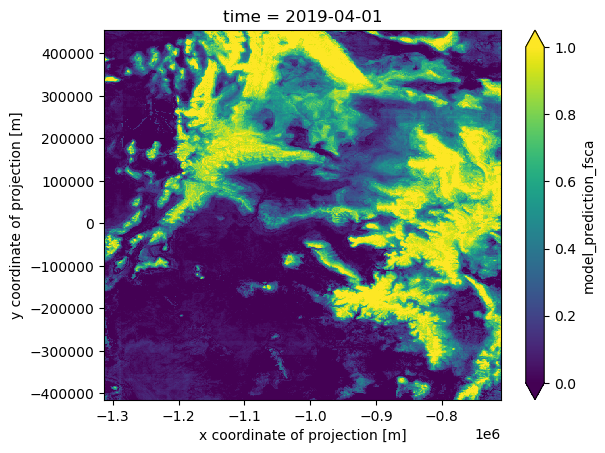

In [31]:
ds_combined["model_prediction_fsca"].isel(time=182).transpose("y", "x").plot(vmin=0, vmax=1)